# How to use with large data? 

It might be than the data set is too large for All Relevant Feature Selection to run in a reasonable time. Usually random sampling (stratified, grouped, etc) solves this issues. If extreme sampling is needed, ARFS provide two methods for decreasing drastically the number of rows. The sampling methods and outcomes are illustrated below.


In [20]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot
from arfs.utils import highlight_tick
from arfs.utils import load_data
from arfs.sampling import sample

plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

In [21]:
%matplotlib inline

In [22]:
gc.enable()
gc.collect()

1223

## Sampling data

A fairly large data set for illustration

In [23]:
# X, y, w = _generated_corr_dataset_regr(size=100_000)

housing = load_data(name='housing')
X, y = housing.data, housing.target

X = pd.DataFrame(X)
X.columns = housing.feature_names
y = pd.Series(y)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## Cleaning the data

In [24]:
%%time
# X is the predictor DF (e.g: df[predictor_list]), at this stage you don't need to 
# specify the target and weights (only for identifying zero and low importance)
fs = arfsfs.FeatureSelector(X=X, y=y, sample_weight=None)
# filter out missing and store in dic

fs.identify_missing(missing_threshold=0.2)
fsDic = {}
fsDic['missing'] = fs.ops['missing']

fs.identify_single_unique()
fsDic['single_unique'] = fs.ops['single_unique']

fs.identify_high_cardinality(max_card=2000)
fsDic['high_cardinality'] =  fs.ops['high_cardinality']

fs.identify_collinear(correlation_threshold=0.5, encode=False)
fsDic['collinear'] = sorted(fs.ops['collinear'])

cols_to_drop = fs.check_removal()
filtered_features = list( set(X.columns) - set(cols_to_drop) )
X_red = X[filtered_features].copy()
# tagging and keeping track of everything
fs_df = fs.tag_df
fs_df

0 features with greater than 0.20 missing values.

0 features with a single unique value.

0 features with a cardinality larger than 2000
Corr matrix done,    0 min and    0 min from start
2 features with a correlation magnitude greater than 0.50.

Total of 2 features identified for removal
CPU times: total: 781 ms
Wall time: 236 ms


,predictor,missing,single_unique,high_cardinality,collinear
0,MedInc,1,1,1,1
1,HouseAge,1,1,1,1
2,AveRooms,1,1,1,0
3,AveBedrms,1,1,1,1
4,Population,1,1,1,1
5,AveOccup,1,1,1,1
6,Latitude,1,1,1,1
7,Longitude,1,1,1,0


In [25]:
data = X_red.copy()
data['target'] = y

In [26]:
print(f"The dataset shape is {data.shape}")

The dataset shape is (20640, 7)


## Random sampling
You can sample using pandas or scikit-learn (providing more advanced random sampling, as stratified sampling, depending on the task).

In [27]:
data_rnd_samp = data.sample(n=1_000)
print(f"The sampled dataset shape is {data_rnd_samp.shape}")

The sampled dataset shape is (1000, 7)


## Sampling by clustering the rows
Using the Gower distance (handling mixed-type data), the rows are clustered and the average/mode for each column is returned. The larger the number of clusters, the closer to the original data. As it requires the computation of a distance matrix, you might need to use random sampling first to avoid a computational bottleneck. 

In [28]:
%%time
data_dum = data.sample(n=10_000)
data_dum = data.copy()
# Compute a distance matrix, 10_000x10_000 and use it for clustering (1_000 clusters)
data_g_samp = sample(df=data_dum, n=1_000, sample_weight=None, method='gower')
print(f"The sampled dataset shape is {data_g_samp.shape}")

The sampled dataset shape is (1000, 7)
CPU times: total: 51.6 s
Wall time: 52.3 s


## Sampling by removing outliers

This method is adapted from BorutaShap. It uses `IsolationForest` to remove the less similar samples and iterates till the 2-sample KS statistics is > $95\%$ (for having a similar distribution than the original data). There is no guarantee of the output size.

In [29]:
%%time
data_isof_samp = sample(df=data, sample_weight=None, method='isoforest')
print(f"The sampled dataset shape is {data_isof_samp.shape}")

The sampled dataset shape is (2064, 7)
CPU times: total: 969 ms
Wall time: 964 ms


## Impact on the feature selection
Let's perform the feature selection on this toy data set to see what is the impact of the different sampling strategies.

Repeated k-fold: 100%|██████████| 25/25 [01:35<00:00,  3.82s/it]


0      AveOccup
1     AveBedrms
2    Population
3      Latitude
4      HouseAge
5        MedInc
Name: feature, dtype: object


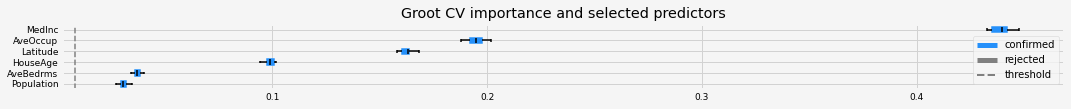

CPU times: total: 9min 56s
Wall time: 1min 36s


In [30]:
%%time
# No Sampling
X = data.drop('target', axis=1)
y = data.target

# GrootCV
feat_selector = arfsgroot.GrootCV(objective='rmse', cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

Repeated k-fold: 100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


0      AveOccup
1     AveBedrms
2    Population
3      Latitude
4      HouseAge
5        MedInc
Name: feature, dtype: object


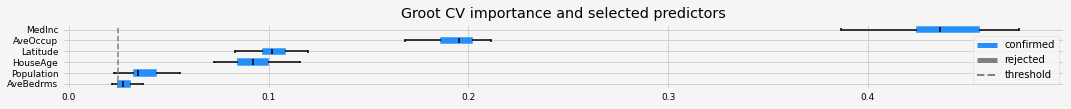

CPU times: total: 25.5 s
Wall time: 4.54 s


In [31]:
%%time

X = data_rnd_samp.drop('target', axis=1)
y = data_rnd_samp.target

# GrootCV
feat_selector = arfsgroot.GrootCV(objective='rmse', cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

Repeated k-fold: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


0      AveOccup
1     AveBedrms
2    Population
3      Latitude
4      HouseAge
5        MedInc
Name: feature, dtype: object


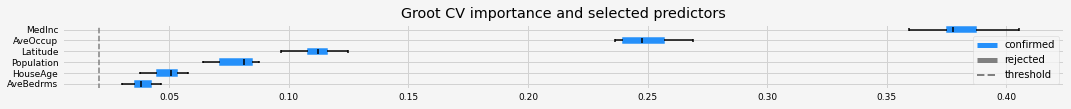

CPU times: total: 37.4 s
Wall time: 6.25 s


In [32]:
%%time

X = data_g_samp.drop('target', axis=1)
y = data_g_samp.target

# GrootCV
feat_selector = arfsgroot.GrootCV(objective='rmse', cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

Repeated k-fold: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


0      AveOccup
1     AveBedrms
2    Population
3      Latitude
4      HouseAge
5        MedInc
Name: feature, dtype: object


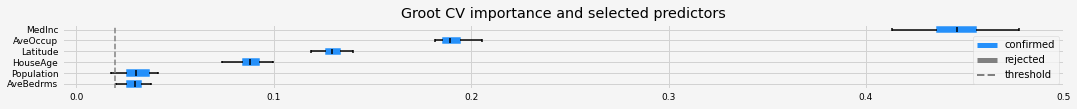

CPU times: total: 42.9 s
Wall time: 6.78 s


In [33]:
%%time

X = data_isof_samp.drop('target', axis=1)
y = data_isof_samp.target

# GrootCV
feat_selector = arfsgroot.GrootCV(objective='rmse', cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()